In [ ]:

import zipfile
import os

### Download and extract dataset

In [ ]:
!wget --no-check-certificate \
"https://drive.google.com/drive/folders/19qBQ59weGBBztDYa1nuSBeqGEQODAAyr.zip" \
-O "/tmp/plant_dataset.zip"

In [ ]:
zip_ref = zipfile.ZipFile('/tmp/plant_dataset.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
data_dir = "/tmp/PlantVillage-Dataset-master/raw/color"

### Import the all essential libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import sys
import os
from keras.applications.vgg16 import VGG16
import keras
from numpy import load
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras import backend
from keras.layers import Dense
from keras.layers import Flatten
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
# from keras.optimizers import SGD
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Dropout
# from keras.layers.normalization import BatchNormalization

In [ ]:
!pip install -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 8.0 MB/s 


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  after removing the cwd from sys.path.


In [ ]:
print(tf.__version__)
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

2.8.2
Default GPU Device: /device:GPU:0


## Image Processing and data augmentation

In [ ]:
batch_size = 32
train_datagenerator = ImageDataGenerator(rescale = 1.0/255,
                                        shear_range = 0.2,
                                        zoom_range = 0.5,
                                        horizontal_flip = True,
                                        rotation_range=10,
                                        width_shift_range=0.2,
                                        brightness_range=[0.2,1.2],
                                        validation_split = 0.2
                                        )
test_datagenerator = ImageDataGenerator(rescale = 1.0/255, validation_split=0.2)

In [ ]:
training_set = train_datagenerator.flow_from_directory(data_dir,
                                                    target_size = (224,224),
                                                    batch_size = 32,
                                                    class_mode = 'categorical',
                                                      subset= "training")

valid_set = test_datagenerator.flow_from_directory(data_dir,
                                                  target_size = (224,224),
                                                    batch_size = 32,
                                                    class_mode = 'categorical',
                                                    subset= "validation")

Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


# **MobileNet model**

In [ ]:
base_model = tf.keras.applications.MobileNet(weights = "imagenet",
                                             include_top = False,
                                             input_shape = (224,224,3))

base_model.trainable = False

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
categories = list(training_set.class_indices.keys())
print(training_set.class_indices)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato

In [ ]:
inputs = keras.Input(shape = (224,224,3))

x = base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(categories), activation="softmax")(x)  # categories is 38

model = keras.Model(inputs = inputs,
                    outputs = x,
                    name="LeafDisease_MobileNet")

In [ ]:
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
              metrics=[keras.metrics.CategoricalAccuracy(),
                       'accuracy'])

In [ ]:
history = model.fit(training_set,
                    validation_data=valid_set,
                    epochs=5,
                    steps_per_epoch=150,
                    validation_steps=100)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


150/150 [==============================] - 93s 515ms/step - loss: 1.8465 - categorical_accuracy: 0.5198 - accuracy: 0.5198 - val_loss: 0.7654 - val_categorical_accuracy: 0.7987 - val_accuracy: 0.7987
Epoch 2/5
150/150 [==============================] - 75s 498ms/step - loss: 0.8132 - categorical_accuracy: 0.7779 - accuracy: 0.7779 - val_loss: 0.5255 - val_categorical_accuracy: 0.8553 - val_accuracy: 0.8553
Epoch 3/5
150/150 [==============================] - 75s 498ms/step - loss: 0.6307 - categorical_accuracy: 0.8150 - accuracy: 0.8150 - val_loss: 0.3803 - val_categorical_accuracy: 0.8934 - val_accuracy: 0.8934
Epoch 4/5
150/150 [==============================] - 73s 489ms/step - loss: 0.5363 - categorical_accuracy: 0.8438 - accuracy: 0.8438 - val_loss: 0.3199 - val_categorical_accuracy: 0.8997 - val_accuracy: 0.8997
Epoch 5/5
150/150 [==============================] - 73s 485ms/step - loss: 0.4949 - categorical_accuracy: 0.8523 - accuracy: 0.8523 - val_loss: 0.3125 - val_categorical_

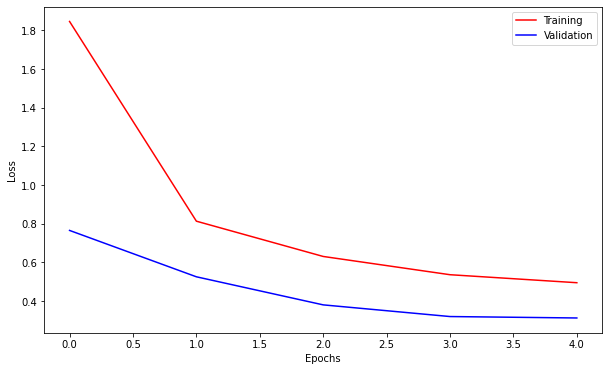

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,c="red",label="Training")
plt.plot(epochs,val_loss,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

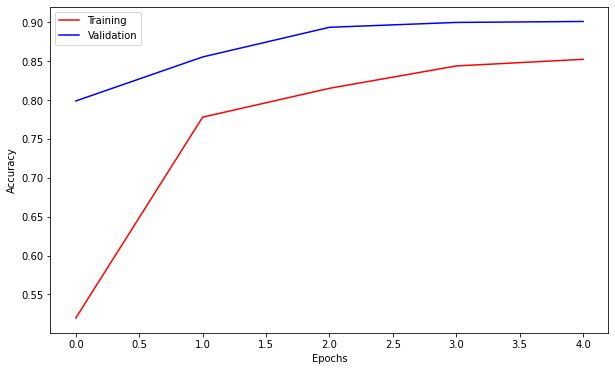

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

epochs = range(len(acc))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,acc,c="red",label="Training")
plt.plot(epochs,val_acc,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [ ]:
model.save('MobileNet model_plant_disease.h5')

# **VGG16 Model**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense
from glob import glob

In [ ]:
base_model=VGG16(include_top=False,input_shape=(224,224,3))
base_model.trainable=False

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
classifier_vgg16=keras.models.Sequential()
classifier_vgg16.add(base_model)
classifier_vgg16.add(Flatten())
classifier_vgg16.add(Dense(38,activation='softmax'))
classifier_vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 38)                953382    
                                                                 
Total params: 15,668,070
Trainable params: 953,382
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
classifier_vgg16.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
train_num = training_set.samples
valid_num = valid_set.samples
print("train_num is:",train_num)
print("valid_num is:",valid_num)

train_num is: 43456
valid_num is: 10849


In [ ]:
history = classifier_vgg16.fit(training_set,
                         steps_per_epoch=150,
                         validation_data=valid_set,
                         epochs=5,
                         validation_steps=100,
                         )

Epoch 1/5
150/150 [==============================] - 88s 565ms/step - loss: 2.2885 - accuracy: 0.4406 - val_loss: 0.9891 - val_accuracy: 0.7356
Epoch 2/5
150/150 [==============================] - 85s 566ms/step - loss: 1.5398 - accuracy: 0.5844 - val_loss: 0.6904 - val_accuracy: 0.7997
Epoch 3/5
150/150 [==============================] - 85s 566ms/step - loss: 1.2680 - accuracy: 0.6485 - val_loss: 0.6982 - val_accuracy: 0.8050
Epoch 4/5
150/150 [==============================] - 85s 563ms/step - loss: 1.2101 - accuracy: 0.6652 - val_loss: 0.6278 - val_accuracy: 0.8169
Epoch 5/5
150/150 [==============================] - 85s 564ms/step - loss: 1.1990 - accuracy: 0.6690 - val_loss: 0.7276 - val_accuracy: 0.8050


In [ ]:
classifier_vgg16.save("vgg16_model_Plant_disease.h5")

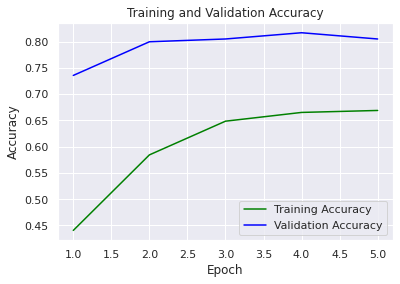

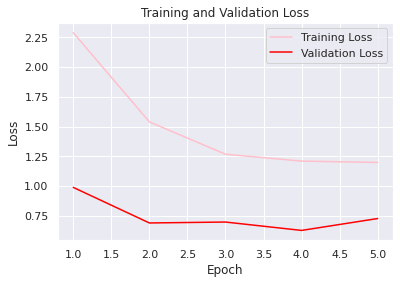

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# **Inception_V3 model**

In [ ]:
# Import the inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
model_inception = InceptionV3(input_shape = (224, 224, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
for layer in model_inception.layers:
  layer.trainable = False

In [ ]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(model_inception.output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (38, activation='sigmoid')(x)

model_inception = Model( model_inception.input, x)

model_inception.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
history = model_inception.fit(training_set,
                         steps_per_epoch=150,
                         validation_data=valid_set,
                         epochs=5,
                         validation_steps=100)

Epoch 1/5
150/150 [==============================] - 82s 514ms/step - loss: 3.0746 - accuracy: 0.4338 - val_loss: 1.2340 - val_accuracy: 0.6534
Epoch 2/5
150/150 [==============================] - 75s 502ms/step - loss: 1.3486 - accuracy: 0.6258 - val_loss: 1.1423 - val_accuracy: 0.6653
Epoch 3/5
150/150 [==============================] - 76s 505ms/step - loss: 1.1111 - accuracy: 0.6823 - val_loss: 0.6829 - val_accuracy: 0.8047
Epoch 4/5
150/150 [==============================] - 76s 504ms/step - loss: 1.0040 - accuracy: 0.7140 - val_loss: 0.7286 - val_accuracy: 0.7862
Epoch 5/5
150/150 [==============================] - 77s 511ms/step - loss: 0.9326 - accuracy: 0.7352 - val_loss: 0.5710 - val_accuracy: 0.8228


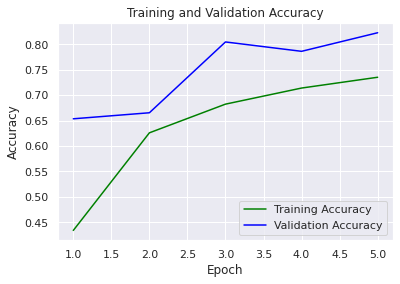

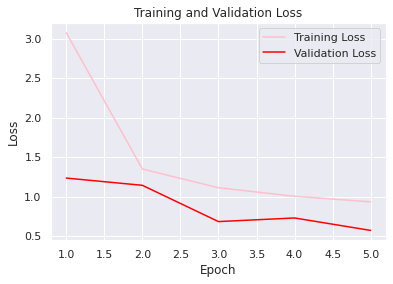

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
model_inception.save("inception_model_plant_disease.h5")

In [ ]:
MobileNet_model = keras.models.load_model("/content/MobileNet model_plant_disease.h5")
Vgg16_model = keras.models.load_model("/content/vgg16_model_Plant_disease.h5")
inception_model = keras.models.load_model("/content/inception_model_plant_disease.h5")

# **VotingEnsemble**

In [ ]:
class_dict = valid_set.class_indices
li = list(class_dict.keys())
print(li)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

Class votingClassifer without using an API

In [ ]:

import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np

class votingClassifer:
    'votingClassifer class'


    def __init__(self, estimators,mode="hard",weight=None,show_info="percent"):

        if mode not in ["hard","soft"]:
            raise Exception("the mode should be 'hard' or 'soft'")

        self.estimators=estimators
        self.mode=mode
        self.weight=weight
        self.show_info=show_info

    def predict(self,x_test):
        if self.mode=="hard":
            return self.votingClassifer_hard(self.estimators, x_test, show_info=self.show_info)
        else:
            return self.votingClassifer_soft(self.estimators, x_test, weight=self.weight, show_info=self.show_info)

    def getNumberDiff(self, index_classes, n):

        for x in index_classes:
            if index_class_prefer != x:
                return x

    def getNumberElse(self, index_classes, n):

        indices = [i for i, value in enumerate(index_classes) if value != n]
        counts = np.bincount(indices)
        ind=np.argmax(counts)
        n1=(indices == ind).sum()


        return n1


    def votingClassifer_hard(self,estimators,x_test,show_info='percent'):

        if show_info not in ["info","percent","nothing"]:
            raise Exception("the attribut 'show_info' should be 'info' or 'percent','nothing'")


        cpt=0
        index_classes_glob, class_names_glob, probs_glob=[],[],[]
        N=len(x_test)
        for x in x_test:
            index_classes, class_names, probs=[],[],[]
            for model in estimators:
                img = np.expand_dims(x, axis=0)
                # make a prediction
                y_prob = model.predict(img)[0]
                probabilty = y_prob.flatten()
                max_prob = probabilty.max()
                y_classes = y_prob.argmax(axis=-1)
                index_class, class_name, prob = y_classes,[y_classes],max_prob
                index_classes.append(index_class)
                class_names.append(class_name)
                probs.append(prob)
            index_classes, class_names, probs = np.array(index_classes), np.array(class_names), np.array(probs)
            counts = np.bincount(index_classes)
            index_class_prefer=np.argmax(counts)

            n1=(index_classes == index_class_prefer).sum()

            if n1 == 1:
                print("\n Each estimator predict a different class")
                prob = probs.max()
                indice = [i for i, value in enumerate(probs) if value == prob][0]
                class_name = class_names[indice]


            elif n1 == len(estimators)/2 and len(estimators)/2 == self.getNumberElse(index_classes, index_class_prefer):

                print("\n the half-estimators predict a class and the other estimators predict a different class")

                indices1 = [i for i, value in enumerate(index_classes) if value == index_class_prefer]
                sum2=0
                for ind in indices1:
                    sum2+=probs[ind]

                prob1=sum2/len(indices1)

                n2=self.getNumberDiff(index_classes, index_class_prefer)

                indices2 = [i for i, value in enumerate(index_classes) if value == n2]
                sum2=0
                for ind in indices2:
                    sum2+=probs[ind]

                prob2=sum2/len(indices2)

                if prob1 < prob2:
                    prob=prob2
                    indice = [i for i, value in enumerate(index_classes) if value == n2][0]
                    class_name = class_names[indice]

                else:
                    prob=prob1
                    indice = [i for i, value in enumerate(index_classes) if value == index_class_prefer][0]
                    class_name = class_names[indice]

            else:

                sum1=0
                nbr=0
                for i, index in zip(range(len(probs)),index_classes):
                    if index_class_prefer== index:
                        sum1+=probs[i]
                        nbr+=1

                prob=sum1/nbr
                indice = index_class_prefer
                class_name = li[index_class_prefer]


            if show_info=="info":
                cpt+=1
                print("\rpercent: {:.2f}%, li[{}]:{} --> {}".format(cpt*100/N,index_class_prefer, li[index_class_prefer], prob), end='')
            elif show_info=="percent":
                cpt+=1
                print("\rpercent: {:.2f}%".format(cpt*100/N), end='')


            index_classes_glob.append(indice)
            class_names_glob.append(class_name)
            probs_glob.append(prob)

        return np.array(index_classes_glob), np.array(class_names_glob), np.array(probs_glob)


    def votingClassifer_soft(self, estimators, x_test, weight=None, show_info="percent"):

        if show_info not in ["info","percent","nothing"]:
            raise Exception("the attribut 'show_info' should be 'info' or 'percent','nothing'")

        if weight is None :
            weight=np.ones(len(estimators))

        if len(weight) != len(estimators):
            raise Exception("number of models and wheight should be equals")

        cpt=0
        # get number of classes
        x = image.img_to_array(x_test[0])
        x = np.expand_dims(x, axis=0)
        y_prob = estimators[0].predict(x)
        num_classes =  y_prob.shape[1]

        Tab=np.zeros(num_classes)# num_classes
        index_classes_glob, class_names_glob, probs_glob=[],[],[]
        N=len(x_test)
        for x in x_test:
            index_classes, class_names, probs= [], [], []
            for model in estimators:
                img = np.expand_dims(x, axis=0)
                # make a prediction
                y_prob = model.predict(img)[0]
                idxs = np.argsort(y_prob)
                # loop over the indexes of the high confidence class labels
                for (index, value) in enumerate(idxs):
                    # build the label and draw the label on the image
                    #label = "{}) {}[{}]: {:.2f}%".format(index,li[value],value, y_prob[value] * 100)
                    #print(label)
                    Tab[value]=y_prob[value]

                probs.append(Tab)

            probs=np.array(probs) # probs.shape: (3, 38)

            proba=[]

            div=sum(weight)
            for i in range(len(probs[0])):
                s=0
                for j in range(len(weight)):
                    s+= probs[j][i] * weight[j]
                s=s/div
                proba.append(s)

            proba=np.array(proba)
            max_prob=max(proba)

            indices=[i for i, value in enumerate(proba) if value == max_prob]

            index_class, class_name, prob=indices[0],li[indices[0]],max_prob

            index_classes_glob.append(index_class)
            class_names_glob.append(class_name)
            probs_glob.append(prob)

            if show_info=="info":
                cpt+=1
                print("percent: {:.2f}%, li[{}]:{} --> {}%".format(cpt*100/N,index_class, li[index_class], prob))
            elif show_info=="percent":
                cpt+=1
                print("\rpercent: {:.2f}%".format(cpt*100/N), end='')



        return np.array(index_classes_glob), np.array(class_names_glob), np.array(probs_glob)

In [ ]:
x_test, y_test = valid_set.next()

Accuracy of each model on 1st set from test dataset

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
models=[MobileNet_model,Vgg16_model,inception_model]
model_names=["MobileNet_model","Vgg16_model", "inception_model"]
for model,model_name in zip(models,model_names):

    y_prob = model.predict(x_test)
    y_pred1 = y_prob.argmax(axis=-1)
    y_test1=np.argmax(y_test, axis=1)
    # accuracy
    print(model_name+" accuracy: ",accuracy_score(y_test1,y_pred1))
    del model , y_pred1, y_test1

MobileNet_model accuracy:  0.9375
Vgg16_model accuracy:  0.8125
inception_model accuracy:  0.78125


**Accuracy**

In [ ]:
# valid_set
x_test, y_test = valid_set.next()

#VotingClassifier(hard)
estimators = [MobileNet_model,Vgg16_model,inception_model]
vc=votingClassifer(estimators=estimators,mode="hard",show_info="percent")
index_classes, class_names, probs=vc.predict(x_test)

percent: 68.75%
 Each estimator predict a different class
percent: 100.00%

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
y_test1=np.argmax(y_test, axis=1)
y_pred1=index_classes

# accuracy
from sklearn.metrics import accuracy_score
print("votingClassifer(hard) accuracy : ",accuracy_score(y_test1,y_pred1))

votingClassifer(hard) accuracy :  0.90625


## confusion_matrix

In [ ]:

print("confusion_matrix")
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
print(confusion_matrix(y_test1,y_pred1))

confusion_matrix
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]]


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
def getWeight(models):
    tab=[]
    cpt=0
    nbr=len(models)
    for model in models:
        y_prob = model.predict(x_test)
        y_pred1 = y_prob.argmax(axis=-1)
        y_test1=np.argmax(y_test, axis=1)
        tab.append(accuracy_score(y_test1,y_pred1))
        cpt+=1
        print("\rpercent: {:.2f}%".format(cpt*100/nbr), end='')

    tab=np.array(tab)
    max_value=max(tab)
    weight=[(x*nbr/max_value) for x in tab]
    weight=getmin_max_indice(np.array(weight))
    return weight

def getmin_max_indice(weight):
    d=sorted(weight, reverse=True)
    a=sorted(weight, reverse=False)
    cpt=0
    for ma,mi in zip(d,a):
        max_indice=[i for i, value in enumerate(weight) if value == ma]
        min_indice=[i for i, value in enumerate(weight) if value == mi]
        c=weight[max_indice]
        weight[max_indice]=weight[min_indice]
        weight[min_indice]=c
        cpt+=1
        if cpt==int(len(weight)/2):
            break
    return weight

models=[MobileNet_model,Vgg16_model,inception_model]
weight=getWeight(models)
print("\nweight=",weight)

percent: 100.00%
weight= [2.6 3.  2.8]


## VotingClassifier(soft)

In [ ]:
#VotingClassifier(soft)
estimators = [MobileNet_model,Vgg16_model,inception_model]
vc=votingClassifer(estimators=estimators,mode="soft",weight=weight,show_info="percent")

index_classes, class_names, probs=vc.predict(x_test)

percent: 100.00%

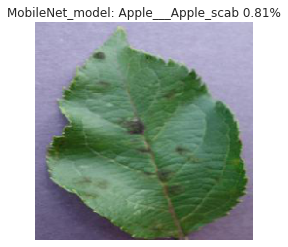

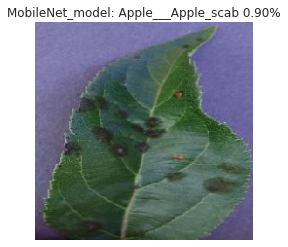

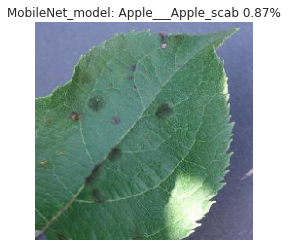

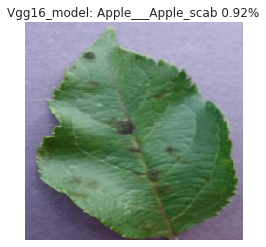

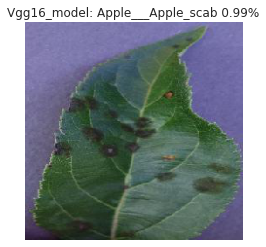

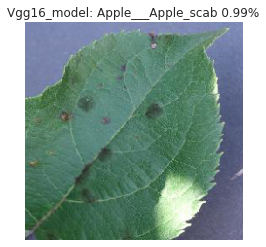

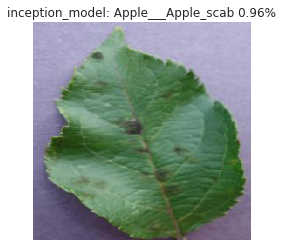

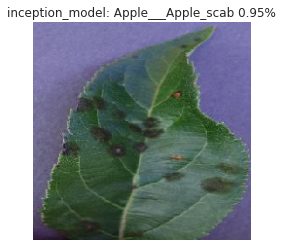

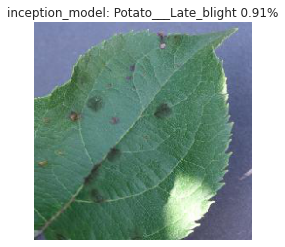

In [ ]:
# predicting an image
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np
directory= "/tmp/PlantVillage-Dataset-master/raw/color/Apple___Apple_scab"
files = [os.path.join(directory,p) for p in sorted(os.listdir(directory))]

models= [MobileNet_model,Vgg16_model,inception_model]
model_names=["MobileNet_model", "Vgg16_model", "inception_model"]
for model,model_name in zip(models,model_names):
    for i in range(0,3):
        image_path = files[i]
        new_img = image.load_img(image_path, target_size=(224, 224))
        img = image.img_to_array(new_img)
        img = np.expand_dims(img, axis=0)
        img = img/255
        prediction = model.predict(img)
        probabilty = prediction.flatten()
        max_prob = probabilty.max()
        index=prediction.argmax(axis=-1)[0]
        class_name = li[index]
        #ploting image with predicted class name
        plt.figure(figsize = (4,4))
        plt.imshow(new_img)
        plt.axis('off')
        plt.title(model_name+": "+class_name+" "+ str(max_prob)[0:4]+"%")
        plt.show()

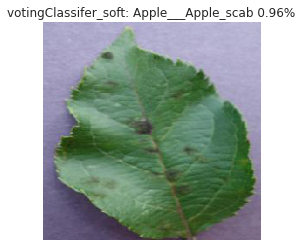

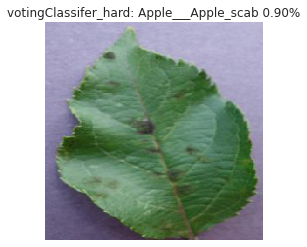

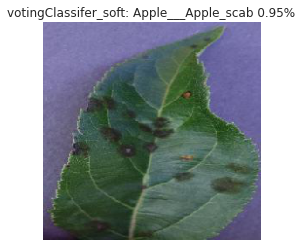

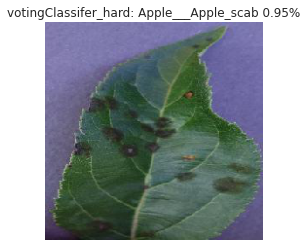

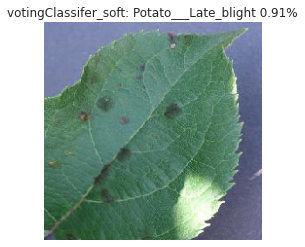

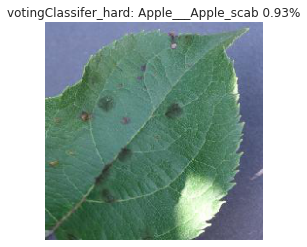

In [ ]:
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np
directory= "/tmp/PlantVillage-Dataset-master/raw/color/Apple___Apple_scab"
files = [os.path.join(directory,p) for p in sorted(os.listdir(directory))]

for i in range(0,3):
    image_path = files[i]
    new_img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(new_img)
    img = np.expand_dims(img, axis=0)
    img = img/255
    model_name="votingClassifer_soft"
    vc=votingClassifer(estimators=estimators,mode="soft",weight=weight, show_info="nothing")
    index_classes, class_names, probs=vc.predict(img)
    #ploting image with predicted class name
    plt.figure(figsize = (4,4))
    plt.imshow(new_img)
    plt.axis('off')
    plt.title(model_name+": "+class_names[0]+" "+str(probs[0])[0:4]+"%")
    plt.show()
    model_name="votingClassifer_hard"
    vc=votingClassifer(estimators=estimators,mode="hard", show_info="nothing")
    index_classes, class_names, probs=vc.predict(img)
    #ploting image with predicted class name
    plt.figure(figsize = (4,4))
    plt.imshow(new_img)
    plt.axis('off')
    plt.title(model_name+": "+class_names[0]+" "+str(probs[0])[0:4]+"%")

    plt.show()